# COMPSCI 589 HW1

#### Name: Haochen Wang

### SECTION 0: Load Libraries

In [1907]:
import sklearn.model_selection
import scipy
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import Counter

### SECTION 2: Evaluating Decision Tree

In [1908]:
# Import Document

house_file = open('house_votes_84.csv', encoding='utf-8-sig')
csvreader = csv.reader(house_file)
houserows = []
for row in csvreader:
    houserows.append(row)

hvcat = houserows[0]
# print(housevotecat)

def catindex(categoryname: str): # a small helper function
    return hvcat.index(categoryname)

#housevotedat = np.array([[int(element) for element in row] for row in houserows[1:]]).T
housevotedat = np.array(houserows[1:]).astype(int)

# print(len(housevotedat))

In [1909]:
# Split to test and training data.

def split_test_train(data, rand):
    housetra, housetes = sklearn.model_selection.train_test_split(data, train_size=0.8, test_size=0.2, random_state=rand, shuffle=True)
    return housetra.T, housetes.T

# housetrain, housetest = split_test_train(housevotedat, 11589)


In [1910]:
# house_file = open('housetest.csv', encoding='utf-8-sig')
# csvreader = csv.reader(house_file)
# houser = []
# for row in csvreader:
#         houser.append(row)

# hvct = houser[0]
# # print(housevotecat)

# hvdt = np.array([[int(element) for element in row] for row in houser[1:]]).T

# print(hvdt)

In [1911]:
# Node Class
class Treenode:
    type = ""
    label = None
    testattribute = ""
    edge = {}
    majority = -1
    # threshold = -1  We don't have numerical here.

    def __init__(self, label, type):
        self.label = label
        self.type = type
        # self.left = left
        # self.right = right


In [1912]:
# Define helper functions that I use in decision tree.

def same(column):
    return all(item == column[0] for item in column)

def majority(column):
    return np.argmax(np.bincount(column))

def entropy(col):
    values = list(Counter(col).values())
    ent = 0
    for value in values:
        k = (value/sum(values))
        ent += -k*math.log(k,2)
    return ent

def gini(col):
    values = list(Counter(col).values())
    ginivalue = 1
    for value in values:
        prob = (value/sum(values))
        ginivalue -= prob**2
    return ginivalue

# test = np.array([1,1,3,3,11,11])
# same(test)
# majority(test)

# test1 = np.array([1,1,0,0,0]) # should get entropy .971, gini .48
# test2 = np.array([1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # should get entropy .940, gini.459
# entropy(test2)

In [1913]:
# Define three test criteria: 
    
# ID3 - Entropy Gain 

def id3(collist, listattribution):
    original_ent = entropy(collist[-1])
    smallest_ent = 1
    i = 0

    # bestindex = i
    best = listattribution[i]
    for attributes in listattribution[:-1]: # I keep the last column: the target/label.
        liskey = list(Counter(collist[i]).keys())
        listofcategory = []
        for value in liskey:
            index = [idx for idx, element in enumerate(collist[i]) if element == value]
            category = np.array(collist[-1][index]) 
            listofcategory.append(category) # list of nparrays of target/label/categories.

        ent = 0
        for cat in listofcategory:
            a = len(cat)/len(collist[i]) # This is probability
            ent += a * entropy(cat) # probability multiple by entropy

        if ent < smallest_ent:
            smallest_ent = ent
            best = attributes
            # bestindex = i
        i+=1

    return best, original_ent-ent

# C4.5 - Entrophy Ratio 
# CART - Gini Impurity
def cart(collist, listattribution):
    smallest_gini = 1
    i = 0
    # bestindex = i
    best = listattribution[i]
    for attributes in listattribution[:-1]: # I keep the last column: the target/label.
        liskey = list(Counter(collist[i]).keys())
        listofcategory = []
        for value in liskey:
            index = [idx for idx, element in enumerate(collist[i]) if element == value]
            category = np.array(collist[-1][index]) 
            listofcategory.append(category) # list of nparrays of target/label/categories.

        gin = 0
        for cat in listofcategory:
            a = len(cat)/len(collist[i]) # This is probability
            gin += a * gini(cat) # probability multiple by gini

        if gin < smallest_gini:
            smallest_gini = gin
            best = attributes
            # bestindex = i
        i+=1

    return best, gin
    

In [1914]:
# Decision Tree
def decisiontree(dataset: np.array, listattributes: list, algortype: str ='id3'):
    def processbest(algor):
        if algor == "id3" or algor == "infogain":
            return id3(datasetcopy, listattricopy)
        elif algor == "cart" or algor == "gini":
            return cart(datasetcopy, listattricopy)
        else: 
            return cart(datasetcopy, listattricopy)

    datasetcopy = np.copy(dataset)
    listattricopy = listattributes.copy()
    
    node = Treenode(label=-1,type="decision")

    node.majority = majority(datasetcopy[-1])

    if same(datasetcopy[-1]):
        node.type = "leaf"
        node.label = datasetcopy[-1][0]
        return node
    
    if len(listattricopy) == 0:
        node.type = "leaf"
        node.label = majority(datasetcopy[-1])
        return node

    bestattribute = processbest(algortype)[0]
    node.testattribute = bestattribute
    bindex = listattricopy.index(bestattribute)

    bigv = list(Counter(datasetcopy[bindex]).keys())

    subdatalists = []
    for smallv in bigv:
        index = [idx for idx, element in enumerate(datasetcopy[bindex]) if element == smallv]
        subdatav = np.array(datasetcopy.T[index]).T
        subdatav = np.delete(subdatav,bindex,0)  # I delete the column I already used using bindex as reference. 
        # Then, later, pop the same index from list attribute.
        subdatalists.append(subdatav) # list of nparrays of target/label/categories.

    listattricopy.pop(bindex)
    
    edge = {}
    sdindex = 0
    for subvdata in subdatalists:
        if subvdata.size == 0:
            node.type = "leaf"
            node.label = majority(subdatav[-1])

        subtree = decisiontree(subvdata, listattricopy, algortype)
        attributevalue = bigv[sdindex]
        edge[attributevalue] = subtree
        sdindex += 1

    node.edge = edge

    return node

In [1915]:
# Prediction using tree

def prediction(tree: Treenode, instance): # note that the instance if by row. (I formerly used by column)
    predict = tree.majority
    correct = instance[-1]
    if tree.type == 'leaf':
        predict = tree.label
        return predict==correct, predict, correct

    testindex = catindex(tree.testattribute)

    if instance[testindex] not in tree.edge:
        return predict==correct, predict, correct
 
    nexttree = tree.edge[instance[testindex]]

    return prediction(nexttree, instance)
    

In [1916]:
# Test with one instance

# instance1 = np.array([1,2,2,1,1,1,2,2,2,1,1,1,2,1,0,0,0])
# print(firsttree.edge[0].edge[2].edge[2].type)
# print(prediction(firsttree,instance1))
# print(len(housetest.T))

def oneaccurcy(data,treeuse):
    yescount = 0
    for ins in data.T:
        if prediction(treeuse,ins)[0]: yescount+=1
    return yescount/len(data.T)


# housetrain, housetest = split_test_train(housevotedat, 608)
# firsttree = decisiontree(housetrain, hvcat, 'id3')
# print(oneaccurcy(housetest,firsttree))
# housetrain, housetest = split_test_train(housevotedat, 201589)
# secondtree = decisiontree(housetrain, hvcat, 'id3')
# print(oneaccurcy(housetest,secondtree))

def manyaccuarcy(datause: str, algorithm: str, rand2number):
    accuracylist = []
    count = 1
    while count <= 100:
        # print(count)
        housetrain, housetest = split_test_train(housevotedat, 589+rand2number*count)
        traintree = decisiontree(housetrain, hvcat, algorithm)
        # print(traintree.edge[0].edge)
        if datause == 'traindata' or datause == 'train':
            oc = oneaccurcy(housetrain,traintree)
        elif datause == 'testdata' or datause == 'test':
            oc = oneaccurcy(housetest,traintree)
        accuracylist.append(oc)
        count+=1

    return accuracylist


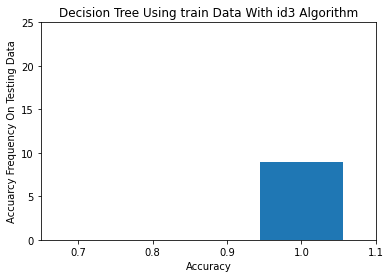

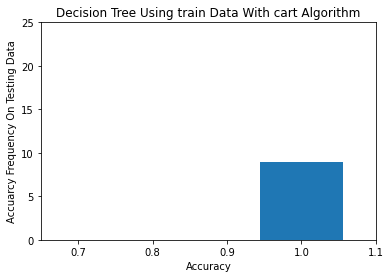

In [1917]:
def plothist(testortrain,algor,rand2):
    plotlist = np.array(manyaccuarcy(testortrain,algor,rand2))
    plt.hist(plotlist,density=1, bins=9) 
    plt.axis([0.65, 1.1, 0, 25]) 
    #[xmin,xmax,ymin,ymax]
    plt.ylabel('Accuarcy Frequency On Testing Data')
    plt.xlabel('Accuracy')
    plt.title("Decision Tree Using "+testortrain+ " Data With " + algor + " Algorithm")
    plt.show()
    return

plothist('train', 'id3', 1)
plothist('train', 'cart', 1)